---
# Single-cell protein abundance and its normalization

In [30]:
## logging functions
import logging
## data functions
import numpy as np
## data functions
import pandas as pd
## system functions
from os.path import dirname,splitext
## system functions from roux
from roux.lib.sys import basenamenoext
from roux.lib.io import to_dict,to_table
## visualization functions
import matplotlib.pyplot as plt
## visualization functions from roux
from roux.viz.diagram import diagram_nb
## visualization functions from roux
from roux.viz.io import to_plot
## data functions from roux
import roux.lib.dfs as rd # attributes

In [2]:
## parameters
input_path=None
segmented_image_path=None
output_path=None
misaligned_fraction_max=0.9
edge_off=None ## remove the cells at the edges

In [6]:
output_dir_path=dirname(output_path)
output_plots_dir_path=splitext(output_path)[0]+'_plots/'
logging.warning(output_dir_path)

In [7]:
diagram_nb(
"""
graph LR;
    N1(["Raw images"])
        --> channel["Pixel intensity\n(e.g. green channel)"] & seg["Segmentation\n(based on\nDIC image)"] 
        seg
            --> segdchannel_filtering["Filter the\nsegmented\nregions"]
            --> map0["Map segmentation\non pixel intensities"]
            --> segdchannel["Abundance\nby single cell"] & bkg["Background intensity"] 
            
        channel
            --> map0
        segdchannel & bkg
            --> norm0(["Normalized\nabundance\nby single cell"])
"""
)

## Segmentation

In [8]:
from htsimaging.lib.io import read_image
a0=read_image(segmented_image_path)

### Label the cells

In [9]:
from skimage import io,measure
regions=measure.label(a0)

In [10]:
ylen,xlen=regions.shape

In [11]:
np.save(f'{output_dir_path}/00_regions_raw.npy',regions)

## Properties of the cells

In [12]:
from skimage import measure

In [13]:
df_=pd.DataFrame(measure.regionprops_table( #New in version 0.16.
    label_image=regions,
    intensity_image=None,
    properties=('label', 
                'bbox', #(min_row, min_col, max_row, max_col)
                'centroid',
                'axis_major_length',
               ), #https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    ))
df_.head(1)

,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,axis_major_length
0,1,13,67,61,113,35.856784,90.082915,49.832156


In [14]:
df_=(
    df_
    .rename(
        columns={
            'label':'cell id','bbox-0':'y1','bbox-1':'x1','bbox-2':'y2','bbox-3':'x2',
            "centroid-0":"centroid x","centroid-1":"centroid y",
            },
        errors='raise'
    )
    .assign(
        **{
            'centroid x reverse':  lambda df: xlen-df['centroid x'],
            'centroid y reverse':  lambda df: ylen-df['centroid y'],
        }
    )
)
df_.head(1)

,cell id,y1,x1,y2,x2,centroid x,centroid y,axis_major_length,centroid x reverse,centroid y reverse
0,1,13,67,61,113,35.856784,90.082915,49.832156,589.143216,534.917085


In [28]:
to_table(df_,f'{output_dir_path}/01_properties.tsv')

'protein_abundance_and_normalization/01_properties.tsv'

### Remove the cells at the edges

[Text(0, 0.5, 'Cells'), Text(0.5, 0, 'Major axis length\n(~max. cell size)')]

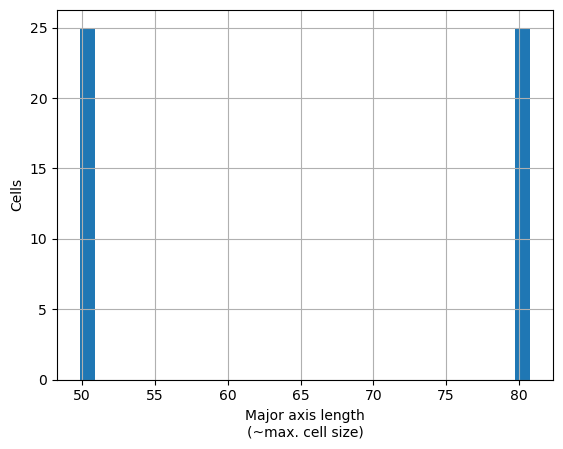

In [17]:
df_['axis_major_length'].hist(bins=30).set(xlabel='Major axis length\n(~max. cell size)',ylabel='Cells')

In [18]:
if edge_off is None:
    edge_off=df_['axis_major_length'].median()
    print(edge_off)

In [19]:
edge_cells=df_.set_index('cell id').filter(regex="^centroid.*").apply(lambda x: x<edge_off).any(axis=1).loc[lambda x: x].index.tolist()
print(len(edge_cells))

0


In [20]:
# df_=df_.log.query(expr=f"~(`cell id` in {edge_cells})")

In [21]:
regions_filtered=regions.copy()
for i in edge_cells:
    regions_filtered[regions_filtered==i]=0

[Text(0.5, 1.0, 'after')]

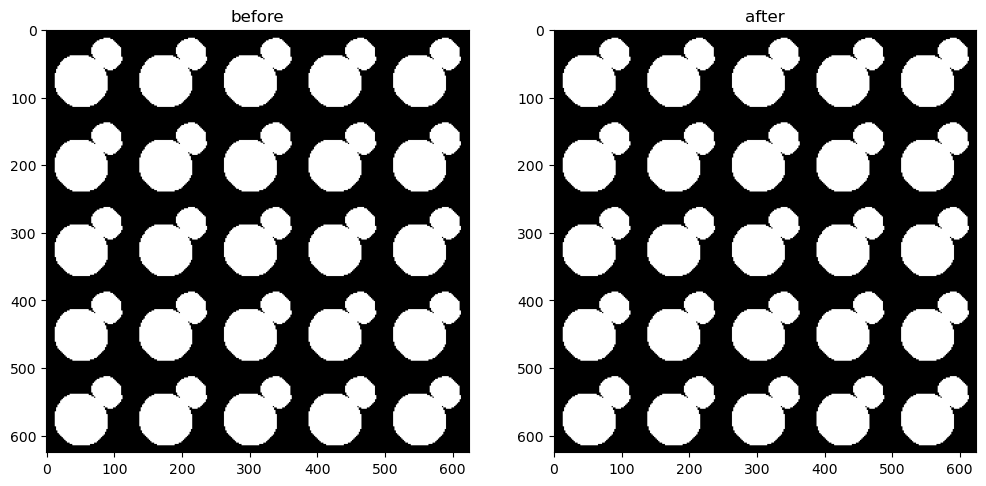

In [22]:
fig,axs=plt.subplots(1,2,figsize=[12,6])
axs[0].imshow(
    regions>0,
    cmap='Greys_r')
axs[0].set(title='before')
axs[1].imshow(
    regions_filtered>0,
    cmap='Greys_r')
axs[1].set(title='after')

In [23]:
to_dict(
    dict(
        edge_off=edge_off,
    ),
     f"{output_dir_path}/01_regions_filtered_stats.json",
)

'protein_abundance_and_normalization/01_regions_filtered_stats.json'

In [24]:
np.save(f'{output_dir_path}/01_regions_filtered.npy',regions_filtered)

## Segmentations mapped onto the channel image

In [25]:
## Channel image
a1=read_image(input_path)

'/mnt/d/Documents/code/htsimaging/examples/protein_abundance_and_normalization/01_gfpby_cell_plots/image_intensity_cells_with_segmentation.png'

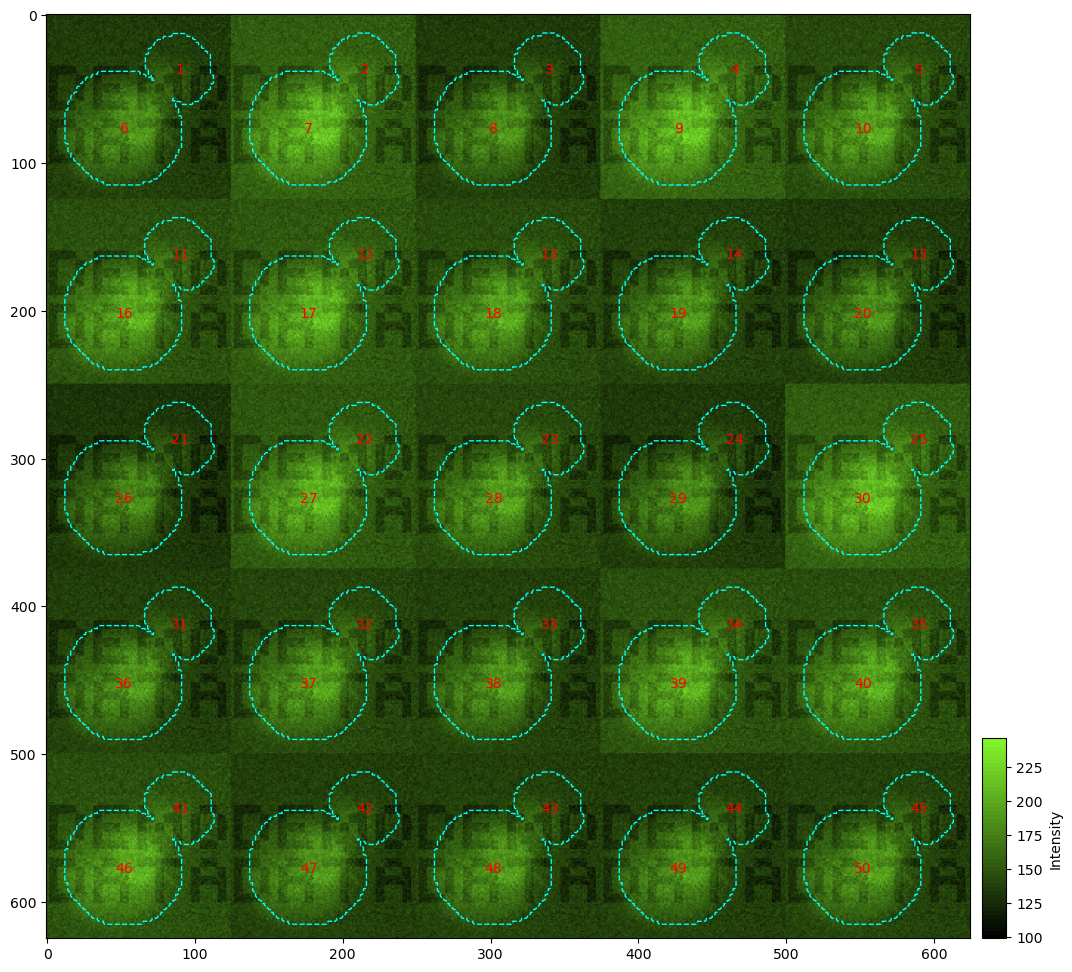

In [31]:
fig,ax=plt.subplots(
    figsize=[12,12],
    )
from htsimaging.viz.image import image_regions_annotated
image_regions_annotated(
    img_region=regions_filtered,
    img=a1,
    cmap='gfp',
    ax=ax,
    )
to_plot(f"{output_plots_dir_path}/{basenamenoext(input_path)}_with_segmentation.png")

### Background intensity

In [32]:
from skimage.segmentation import expand_labels

In [33]:
regions_expanded=expand_labels(
    regions, # unfiltered
    distance=edge_off,
    )

'/mnt/d/Documents/code/htsimaging/examples/protein_abundance_and_normalization/01_gfpby_cell_plots/image_intensity_cells_background.png'

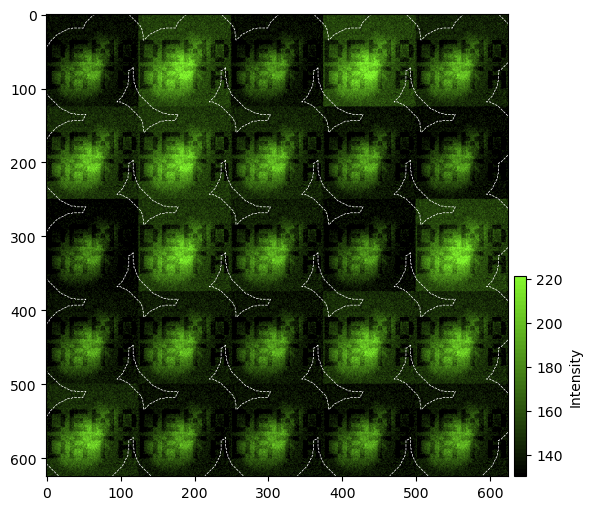

In [34]:
fig,ax=plt.subplots(1,1,figsize=[6,6])
from htsimaging.viz.image import image_background
image_background(
    img_region=regions_expanded,
    img=a1,
    cmap='gfp',
    alpha=1,
    linewidths=0.5,
    colors='w',
    kws_region={},
    show_scalebar=None,
    scalebar_color='w',
    test=False,
    ax=ax,
    vmin=np.quantile(a1,0.1),
    vmax=np.quantile(a1,0.999),
    # **kws_img,
    )
## only regions
# ax.imshow(
#     regions_expanded>0,
#     cmap='Greys_r')
to_plot(f"{output_plots_dir_path}/{basenamenoext(input_path)}_background.png")

In [35]:
df_=(pd.DataFrame({
    'cell id':regions_expanded.ravel(),
    'intensity':a1.ravel(),
    })
    .query(f"`cell id` == 0") ## get background
    )
df_.head(1)

,cell id,intensity
0,0,132.215809


[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Intensity')]

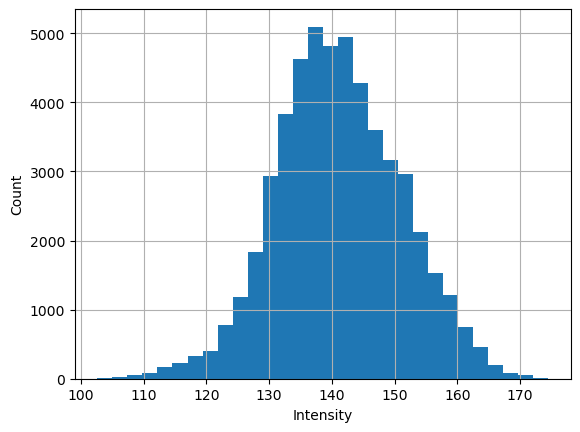

In [36]:
df_['intensity'].hist(bins=30).set(xlabel='Intensity',ylabel='Count')

In [37]:
df_['intensity'].describe().astype(int)

count    51775
mean       141
std          9
min        102
25%        134
50%        140
75%        147
max        174
Name: intensity, dtype: int64

In [38]:
background_intensity=df_['intensity'].median()

## Map the segmentation to the filtered segmentation

In [39]:
df1=(pd.DataFrame({
    'cell id':regions_filtered.ravel(),
    'intensity':a1.ravel(),
    })
    .log.query(expr=f"`cell id` != 0") ## remove background
    .log('cell id')
    )
df1.head(1)

,cell id,intensity
8210,1,140.715396


### Check for the misalignment between the segmentation and the channel

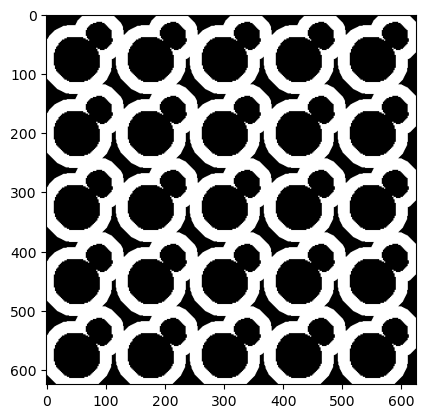

In [40]:
regions_expanded_areas=(regions==0) & (regions_expanded!=0)
plt.imshow(regions_expanded_areas,cmap='Greys_r')

In [41]:
## get channel intensity in the expanded areas
df_=(pd.DataFrame({
    'area':regions_expanded_areas.ravel(),
    'intensity':a1.ravel(), ## channel intensity
    })
    .query(f"`area` == True") ## get background
    )
df_.head(1)

,area,intensity
65,True,125.605018


[Text(0, 0.5, 'Pixels'), Text(0.5, 0, 'Intensity')]

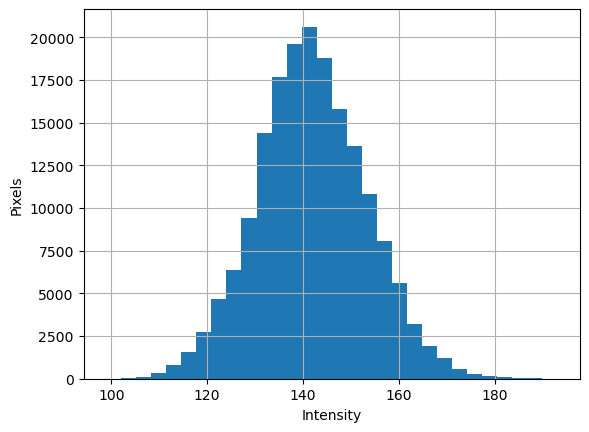

In [42]:
df_['intensity'].hist(bins=30).set(xlabel='Intensity',ylabel='Pixels')

In [43]:
misaligned_area_intensity=df_['intensity'].median()

In [44]:
misaligned_fraction=(misaligned_area_intensity/df1['intensity'].median())
print(misaligned_fraction)

0.8854540132729521


In [45]:
if misaligned_fraction>=misaligned_fraction_max:
    logging.warning("Possible misalignment between he segmentation and the channel")

### Abundance by single cell

In [46]:
df2=(df1
    .groupby('cell id')
    .agg(
        **{
            "abundance":("intensity",np.median),
        })
    .reset_index()
    ## normalize
    .assign(
          **{
              'abundance normalized':lambda df: df['abundance']/background_intensity,
          }
    )
    )
df2.head(1)

,cell id,abundance,abundance normalized
0,1,139.770998,0.993611


[Text(0, 0.5, 'Cells'), Text(0.5, 0, 'Intensity')]

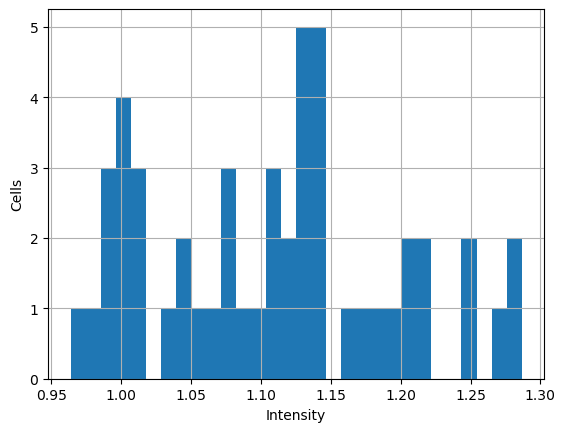

In [47]:
df2['abundance normalized'].hist(bins=30).set(xlabel='Intensity',ylabel='Cells')

In [48]:
## save stats
to_dict(
    dict(
        background_intensity=background_intensity,
        misaligned_area_intensity=misaligned_area_intensity,
        misaligned_fraction=misaligned_fraction,
    ),
     f"{splitext(output_path)[0]}_stats.json",
)

'protein_abundance_and_normalization/01_gfpby_cell_stats.json'

In [49]:
## save table with abundances
to_table(df2,output_path)

'protein_abundance_and_normalization/01_gfpby_cell.tsv'